# **Transverse Field Ising Model**

## Index

- [Transverse Field Ising Model](#transverse-field-ising-model)
    - [Introduction](#introduction)
    - [Ground States and Symmetry](#ground-states-and-symmetry)
    - [Setting up the Hamiltonian](#setting-up-the-qubithamiltonian-in-quri)
- [VQE Optimization](#vqe-optimization)
    - [Cost and Gradient Estimators](#cost-function-and-gradient-estimators)
    - [Setting up VQE Optimization loop](#setting-up-vqe-optimization-loop)
    - [Benchmarking with different Ansatz](#benchmarking-with-different-ansatz)
- [Statistical Phase Estimation](#statistical-phase-estimation-spe)
    - [Picking the Trial State](#trial-state)
    - [Hadamard Test](#hadamard-test)
    - [Qubit Hamiltonian and Trotterization](#qubit-hamiltonian-and-trotterization)
    - [LT22](#lt22)
- [QSCI](#qsci)
- [Quantum Phase Transition](#quantum-phase-transition)
    - [Computing Exact Ground State](#computing-ground-state-for-hj-in-01-5)
    - [Magnetization](#magnetization)
    - [Magnetic Susceptibility](#magnetic-susceptibility)
- [Reference](#reference)

*The goal of this tutorial will be to implement Transverse Field Ising Models (TFIM) using QURI-SDK. We will approximate the ground state of the TFIM Hamiltonian using VQE and further improving it using SPE, QSCI. Finally we will calculate the magnetization, magentic susceptibility and show divergence at the critical point (Quantum Phase Transition) which are relevant to Condensed Matter Physicist.*

## Introduction

Ising Model started out as a theoretical model to explain ferromagnetism in solids. It assumes only nearest neighbor interaction between two opposite orientations of magnetic moment at lattice sites. For details, see [Ising model](https://www.thphys.uni-heidelberg.de/~wolschin/statsem20_3s.pdf).

Over time, Ising models have been applied to various other fields such as *Machine Learning (Hopfield networks)*, *Biology (Protein folding)*, etc. The **Transverse Field Ising Model (TFIM)**, which is the main part of this notebook, is a quantum version of the Ising model, where spins are replaced by qubits and the interaction between spins is modified by a transverse magnetic field. This model is used to study quantum phase transitions and has applications in Quantum Computing and Condensed Matter Physics.

From a Computer Science perspective, NP-hard problems, including all of Karp's 21 NP-complete problems can be mapped to the Ising model with a polynomial overhead. Thus, any NP-hard problem can be reduced to finding the ground state of the Ising model. For further reference, look at [Ising formulations of NP-Complete problems](https://www.frontiersin.org/journals/physics/articles/10.3389/fphy.2014.00005/full).


The Hamiltonian of the Transverse Field Ising Model is given by:

$$H = -J\sum_{i=1}^{N} X_i X_{i+1} - h\sum_{i=1}^N Z_i$$

- *$X$:* The Pauli $\sigma_x$ matrix (for spin measurement)
- *$Z$:* The Pauli $\sigma_z$ matrix (for transverse field) 
- *Ferromagnetic coupling ($J$)*: Favors alignment of neighboring spins along X.  
- *Transverse field ($h$)*: Induces quantum fluctuations, polarizing spins along J.
- The boundary condition is periodic, meaning the last spin interacts with the first spin.

**Note:** In most references, the Hamiltonian will have Pauli matrices in the opposite order, i.e., $H = -J\sum_{i=1}^{N-1} Z_{i+1} Z_i - h\sum_{i=1}^N X_i$. This is due to the convention of defining the spin along Z axis in Condensed Matter Physics. The reason we switch Pauli X and Z is due to the Z2 ansatz we will be using for the VQE. Everything else remains the same, if you are doing any calculation wrt to the standard TFIM Hamiltonian, just switch the Pauli matrices.

### Ground States

##### *h >> J (Spin Polarised Phase):* 
Spin-polarized states TO refers states where electron spins in a material are not randomly oriented but rather exhibit a net alignment in a particular direction, leading to a non-zero spin polarization. When $h$ is much larger than $J$, the spins tend to align along the Z-axis (spin-polarized states). One of the fully spin-polarised states is:
$$
|\psi^{0+}\rangle = \otimes_{n=1}^N | \uparrow \rangle_n
$$ 
The energy eigenvalue is $\approx -hN$ and magnetization = $N$, where $N$ is the number of spins.

##### *J >> h (Ferromagnetic Phase):* 
When $J$ is much larger than $h$, the spins tend to be aligned along the X-axis, forming an equal superposition of $| \uparrow \rangle$ and $| \downarrow \rangle$. The two ground states are:
$$
|\psi_{0\to}\rangle = \bigotimes_{n=1}^N \frac{1}{\sqrt{2}} \left( | \uparrow \rangle_n + | \downarrow \rangle_n \right)
$$

$$
|\psi_{0\leftarrow}\rangle = \bigotimes_{n=1}^N \frac{1}{\sqrt{2}} \left( | \uparrow \rangle_n - | \downarrow \rangle_n \right)
$$

Formally, any superposition of these two states is also a ground state. But in the thermodynamic limit $(N \to \infty)$, such symmetric superpositions are not stable. To tunnel between the two states requires flipping $O(N)$ spins, so the tunneling amplitude goes to zero exponentially with N. As a result, the system chooses one of the two magnetization directions even at zero temperature. This is known as Spontaneous Symmetry breaking.

### Symmetry

The $\mathbb{Z}_2$ symmetry corresponds to a *global spin-flip* operation:
$ G = \otimes_i \sigma_i^z, $
which satisfies $G^2 = 1$, forming the cyclic group $\mathbb{Z}_2$.

Interaction term $\sigma_i^x \sigma_j^x$:
  $\quad G (\sigma_i^x \sigma_j^x) G^{-1} = \sigma_i^x \sigma_j^x \quad (\text{invariant}).$

Transverse field term $\sigma_i^x$:
  $\quad G (\sigma_i^z) G^{-1} = \sigma_i^z \quad (\text{invariant}).$

The Hamiltonian $H$ is invariant under $G$, confirming $\mathbb{Z}_2$ symmetry.

### Setting up the QubitHamiltonian in QURI

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence
from quri_parts.core.operator import Operator, pauli_label, get_sparse_matrix

def construct_TFIM_hamiltonian(J: float, h: float, n_qubits: int) -> Operator:
    hamiltonian = Operator()

    # Add Ising interaction terms (-J Σ X_i X_{i+1}) (Assuming periodic boundary conditions)
    for i in range(n_qubits):
        pauli_index = pauli_label('X'+str(i)+' X'+str((i+1)%n_qubits))
        hamiltonian.add_term(pauli_index, -J)

    # Add transverse field terms (-h Σ Z_i)
    for i in range(n_qubits):
        pauli_index = pauli_label('Z'+str(i))
        hamiltonian.add_term(pauli_index, -h)

    return hamiltonian

In [ ]:
# Parameters
n_qubits = 12       # Number of spins/qubits
J = 1.0             # Interaction strength
h = 1.0             # Transverse field strength

hamiltonian = construct_TFIM_hamiltonian(J, h, n_qubits)

Since *n_qubits* is small, we can find the smallest eigenvalue (ground energy state) of the Hamiltonian matrix directly. This is only performed for benchmarking. For relistic physical systems involving large *n_qubits*, this computation is not feasible and we have to rely on Quantum Computing methods to find the approximate ground state.

In [ ]:
## Ground eigenvalue and eigenvector computation using numpy (Will be later used for benchmarking)
vals, vecs = np.linalg.eigh(get_sparse_matrix(hamiltonian).toarray())

EXACT_GS_ENERGY = np.min(vals)
EXACT_GAP = vals[np.argsort(vals)][:2] @ [-1, 1]

print("E_0:", EXACT_GS_ENERGY)
print("Delta (E_1 - E_0)):", EXACT_GAP)

E_0: -15.322595151080774
Delta (E_1 - E_0)): 0.13108692563047342


## **VQE Optimization**

In case you're new to QURI SDK's implementation of Variational algorithms, you may refer to this tutorial [Variational Algorithms](https://quri-sdk.qunasys.com/docs/tutorials/quri-parts/advanced/variational/).

### Cost Function and Gradient Estimators

We will first define closures (higher-order functions) that takes the Hamiltonian and parametric quantum state as the parameter and returns cost function and gradient estimators for the VQE optimization. The `cost estimator` computes the expectation value of the Hamiltonian with respect to the parametric state, while the `gradient estimator` computes the gradient of the expectation value with respect to the parameters of the parametric state.

In [ ]:
from quri_parts.core.estimator.gradient import create_parameter_shift_gradient_estimator
from quri_parts.qulacs.estimator import create_qulacs_vector_concurrent_parametric_estimator, create_qulacs_vector_parametric_estimator

from quri_parts.core.state import ParametricCircuitQuantumState
from typing import Callable
import numpy.typing as npt

estimator = create_qulacs_vector_parametric_estimator()

def cost_fn_estimator(hamiltonian : Operator, parametric_state: ParametricCircuitQuantumState) -> Callable[[Sequence[float]], Sequence[float]]:
    return lambda param_values : estimator(hamiltonian, parametric_state, param_values).value.real

In [ ]:
concurrent_parametric_estimator = create_qulacs_vector_concurrent_parametric_estimator()
gradient_estimator = create_parameter_shift_gradient_estimator(concurrent_parametric_estimator)

def grad_fn_estimator(hamiltonian : Operator, parametric_state: ParametricCircuitQuantumState) -> Callable[[Sequence[float]], npt.NDArray[np.float64]]:
    return lambda param_values: np.real(gradient_estimator(hamiltonian, parametric_state, param_values).values)

### Setting up VQE Optimization loop

Next, we will set up the VQE optimization loop essentially updating the parameters of the parametric state using the Gradient descent method and a momentum based optimizer (e.g. Adam). QURI Parts provides a convenient `OptimizerStatus` class that will handle the optimizer convergence for us. 

The below `vqe` function takes the parametric circuit (Ansatz), hamiltonian, initial parameters, optimizer and returns the optimzied ground state, optimized params , log of ground state energy, and the number of iterations taken to converge.

In [ ]:
from quri_parts.algo.optimizer import Adam, Optimizer, OptimizerStatus
from quri_parts.circuit import ImmutableLinearMappedParametricQuantumCircuit
from quri_parts.core.state import quantum_state, apply_circuit

def vqe(
    parametric_circuit : ImmutableLinearMappedParametricQuantumCircuit, 
    hamiltonian : Operator,
    init_params: Sequence[float] = None,
    optimizer : Optimizer = Adam()
):
    # Setting up the parametric state
    cb_state = quantum_state(n_qubits, bits=0)
    parametric_state = apply_circuit(parametric_circuit, cb_state)

    # Defining the cost and gradient estimators based on the hamiltonian and parametric state
    cost_fn = cost_fn_estimator(hamiltonian, parametric_state)
    grad_fn = grad_fn_estimator(hamiltonian, parametric_state)


    # Intializing to random parameters if params not provided
    if init_params is None:
        init_params = np.random.random(parametric_circuit.parameter_count)
    
    opt_state = optimizer.get_init_state(init_params)
    energy = []

    # Running the VQE Optimization loop
    while True:
        opt_state = optimizer.step(opt_state, cost_fn, grad_fn)
        energy.append(opt_state.cost)

        if opt_state.status == OptimizerStatus.FAILED:
            print("Optimizer failed")
            break
        if opt_state.status == OptimizerStatus.CONVERGED:
            print("Optimizer converged")
            break

    bound_state = parametric_state.bind_parameters(opt_state.params)
    return bound_state, opt_state.params, energy, opt_state.niter

### Benchmarking with different Ansatz

#### *Symmetry Preserving Real Ansatz*

The `SymmetryPreservingReal` respects particle number, total spin, spin projection, and time-reversal symmetries of the initial state. For further details, refer to this [paper](https://www.nature.com/articles/s41534-019-0240-1)

In [ ]:
from quri_parts.algo.ansatz import SymmetryPreserving
from quri_parts.circuit.utils.circuit_drawer import draw_circuit

spr_parametric_circuit = SymmetryPreserving(n_qubits, 7)
#draw_circuit(spr_parametric_circuit)

In [ ]:
spr_bound_state, spr_params, spr_ground_energy, spr_num_iter = vqe(spr_parametric_circuit, hamiltonian)
print("Optimized value:", spr_ground_energy[-1])
print("Error:", np.abs(EXACT_GS_ENERGY - spr_ground_energy[-1]))
print("Iterations:", spr_num_iter)

Optimizer converged
Optimized value: -11.999999999999964
Error: 3.32259515108081
Iterations: 1


#### *Z2 Symmetry Preserving Real Ansatz*

The `Z2SymmetryPreservingReal` ansatz is based of preserving the $\mathbb{Z}_2$ symmetry of the TFIM Hamiltonian we had defined at the start. For further details on the Z2 ansatz, refer to this [paper](https://arxiv.org/abs/2404.08548).

In [ ]:
from quri_parts.algo.ansatz import Z2SymmetryPreservingReal

z2_parametric_circuit = Z2SymmetryPreservingReal(n_qubits, 7)
draw_circuit(z2_parametric_circuit)

                           ___     ___     ___                             ___  
                          |PR |   |PRZ|   |PR |                           |PR | 
--------------------------|20 |---|21 |---|23 |---------------------------|64 |-
                          |   |   |___|   |   |                           |   | 
   ___     ___     ___    |   |    ___    |   |    ___     ___     ___    |   | 
  |PR |   |PRZ|   |PR |   |   |   |PRZ|   |   |   |PR |   |PRZ|   |PR |   |   | 
--|0  |---|1  |---|3  |---|   |---|22 |---|   |---|44 |---|45 |---|47 |---|   |-
  |   |   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |   |   |___| 
  |   |    ___    |   |    ___     ___     ___    |   |    ___    |   |    ___  
  |   |   |PRZ|   |   |   |PR |   |PRZ|   |PR |   |   |   |PRZ|   |   |   |PR | 
--|   |---|2  |---|   |---|24 |---|25 |---|27 |---|   |---|46 |---|   |---|68 |-
  |___|   |___|   |___|   |   |   |___|   |   |   |___|   |___|   |___|   |   | 
   ___     ___     ___    | 

In [ ]:
Z2_bound_state, Z2_params, Z2_ground_energy, Z2_num_iter = vqe(z2_parametric_circuit, hamiltonian)
print("Optimized value:", Z2_ground_energy[-1])
print("Error:", np.abs(EXACT_GS_ENERGY - Z2_ground_energy[-1]))
print("Iterations:", Z2_num_iter)

Optimizer converged
Optimized value: -15.314098481394302
Error: 0.008496669686472558
Iterations: 181


#### *Hardware Efficient Real Ansatz*

The `HardwareEfficientReal` ansatz is a variational ansatz that is specifically meant for small molecules and quantum magnets. For further details on the HardwareEfficientReal ansatz, refer to this [paper](https://www.nature.com/articles/nature23879).

In [ ]:
from quri_parts.algo.ansatz import HardwareEfficientReal

hardware_parametric_circuit = HardwareEfficientReal(n_qubits, 7)
# draw_circuit(hardware_parametric_circuit)

In [ ]:
he_bound_state, he_params, he_ground_energy, he_num_iter = vqe(hardware_parametric_circuit, hamiltonian)
print("Optimized value:", he_ground_energy[-1])
print("Error:", np.abs(EXACT_GS_ENERGY - he_ground_energy[-1]))
print("Iterations:", he_num_iter)

Optimized value: -15.194860596846603
Error: 0.12773455423417523
Iterations: 67


Based on the above test runs, we can clearly rule out `SymmetryPreservingReal` ansatz.

#### *Ground State Energy Convergence Plot*

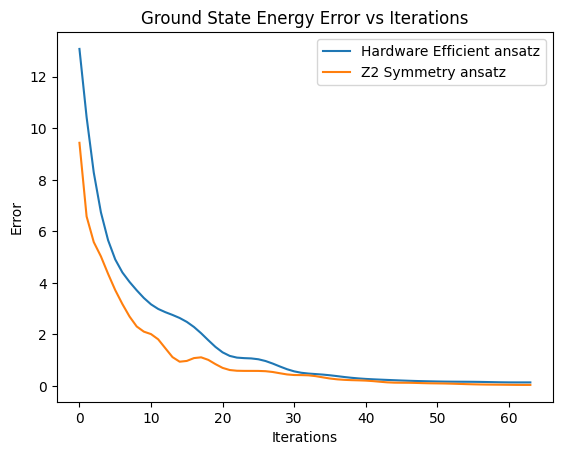

In [ ]:
plt.title("Ground State Energy Error vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Error")

x = min(len(he_ground_energy), len(Z2_ground_energy))
plt.plot(np.abs(EXACT_GS_ENERGY - he_ground_energy[:x]), label="Hardware Efficient ansatz")
plt.plot(np.abs(EXACT_GS_ENERGY - Z2_ground_energy[:x]), label="Z2 Symmetry ansatz")
plt.legend()
plt.show()

From the convergence plot for ground state energy for the `Z2SymmetryPreservingReal` and `HardwareEfficientReal` ansatz, we can see that the `Z2SymmetryPreservingReal` ansatz performs the best in terms of convergence and accuracy of the ground state energy (order of magnitude better). The `HardwareEfficientReal` ansatz also performs well but has slower convergence which become a bottleneck for higher number of qubits.

We will be using the `Z2SymmetryPreservingReal` ansatz for the rest of the tutorial, i.e. optimizing the ground state obtained from VQE further using SPE and QSCI.

## **Statistical Phase Estimation (SPE):**

Statistical Phase Estimation (SPE) is a ground state energy estimation algorithm meant to run on Early Fault Tolerant Quantum Computing (EFTQC) architectures. The benefit of SPE is that it needs a shorter depth circuit than Quantum Phase Estimation (QPE), which requires longer circuit depth and fully fault tolerant architecture due to full Quantum Fourier Transform (QFT). For further details on SPE, you can refer to this [notebook](https://github.com/QunaSys/quri-sdk-notebooks/blob/main/quri_sdk_notebooks/examples/0_quri-algo-vm/1_spe/1_spe.ipynb) or the [original paper](https://arxiv.org/abs/2409.07749)

### Trial State

The goal of phase estimation is to estimate the phase $\phi$ in 
$U|\psi\rangle = e^{2\pi i \phi} |\psi\rangle$. But this only makes sense if we have a trial state $|\psi\rangle$ is an eigenstate of $U$.

In practice, we don't have access to the exact eigenstate of the Hamiltonian $H$, so we need to use a trial state which we hope has some overlap with the ground state.

$$U|\psi_{\text{trial}}\rangle = \sum_{j} c_j |\phi_j\rangle$$

$$U^k|\psi_{\text{trial}}\rangle = \sum_{j} c_j e^{2\pi i k \phi_j} |\phi_j\rangle$$

When you measure and statistically analyze the results, the phase estimation algorithm **amplifies the dominant phase(s)** — especially those for which $|c_j|^2$ is largest. We will be using the ground state obtained from the VQE optimization as the trial state for the SPE algorithm.

In [ ]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector

gs_overlap = np.abs(evaluate_state_to_vector(Z2_bound_state).vector @ vecs[:, 0])**2
print(f"Overlap between the chosen state and the exact grounds state vector: {gs_overlap: .1e}")

Overlap between the chosen state and the exact grounds state vector: 0.94e-01


### Hadamard Test

The **Hadamard test** is the core measurement primitive, it enables estimation of the complex-valued function:

$$
\hat{\mu}(t) = \langle \psi | U(t) |\psi \rangle = \langle \psi | e^{-iHt} | \psi \rangle = \sum_j |c_j|^2 e^{-i \lambda_j t}
$$
where $ |\psi\rangle = \sum_j c_j |\phi_j\rangle $ is the trial state, and $ U(t) $ evolves under the Hamiltonian $ H $.

To perform the Hadamard test we first calculate the state  $\frac{1}{\sqrt{2}} \left( |0\rangle + |1\rangle \right) \otimes |\psi\rangle$ We then apply the unitary operator on $|\psi\rangle$ conditioned on the first qubit to obtain the state  $\frac{1}{\sqrt{2}} \left( |0\rangle \otimes |\psi\rangle + |1\rangle \otimes U |\psi\rangle \right).$  

We then apply the **Hadamard gate** to the first qubit, yielding  $\frac{1}{2} \left( |0\rangle \otimes (I + U) |\psi\rangle + |1\rangle \otimes (I - U) |\psi\rangle \right).$

Measuring the first qubit, the result is $|0\rangle$ with probability $\frac{1}{4} \langle \psi | (I + U^\dagger)(I + U) | \psi \rangle $ in which case we output 1. 

The result is $|1\rangle$ with probability $\frac{1}{4} \langle \psi | (I - U^\dagger)(I - U) | \psi \rangle $
, in which case we output -1.  

The expected value of the output will then be the difference between the two probabilities, which is $\frac{1}{2} \langle \psi | (U^\dagger + U) | \psi \rangle = \text{Re} \langle \psi | U | \psi \rangle.$

To obtain a random variable whose expectation is  $\text{Im} \langle \psi | U | \psi \rangle$  follow exactly the same procedure but start with $\frac{1}{\sqrt{2}} \left( |0\rangle - i |1\rangle \right) \otimes |\psi\rangle$

#### Qubit Hamiltonian and Trotterization

The SPE algorithm esimtates $<e^{-iHt}>$ using Hadamard Test on different evolution time $t$ to obtain $\hat{\mu}(t)$. We can then take the Fourier transform of $\hat{\mu}(t)$ to find the spectral denisty $\mu(\lambda)$ — the phases (eigenvalues) weighted by $|c_j|^2$. 

Now, in order to perform $U = e^{-iHt}$ in Hadamard test, we require Trotterization on near term devices to approximate the exponential of a Hamiltonian as a sequence of simple unitary operations. In QURI SDK we need to encode our Hamiltonian into a controlled time evolution circuit U = $e^{-i H t}$ using time evolution with Trotterization. This is done by wrapping the hamiltonian into `QubitHamiltonianInput` for encoding into a circuit later.

In [ ]:
from quri_algo.problem import QubitHamiltonian

qubit_hamiltonian = QubitHamiltonian(n_qubits, hamiltonian)

The SPE algorithm requires an esimtation of $<e^{-iHt}>$ on different evolution time $t$. We build an estimator based on Hadamard test with Trotterized time evolution operator.

In [ ]:
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterControlledTimeEvolutionCircuitFactory
from quri_algo.core.estimator.time_evolution.trotter import TrotterTimeEvolutionHadamardTest


# Setting the num_trotter steps to 30
trotter_concotrolled_time_evo_circuit_factory = (
    TrotterControlledTimeEvolutionCircuitFactory(qubit_hamiltonian, n_trotter=30)
)

# Time-evolution with t=1
c_time_evo = trotter_concotrolled_time_evo_circuit_factory(evolution_time=1)

sampler = create_qulacs_vector_sampler()
trotter_time_evolution_estimator = TrotterTimeEvolutionHadamardTest(qubit_hamiltonian, sampler, n_trotter=50)

### LT22

[LT22](http://arxiv.org/abs/2102.11340) refers to the filter-based method for spectral estimation by Lin and Tong. The core idea is to take the Fourier transform of the estimated spectral density $\mu(\lambda)$ to obtain the eigenvalues of the Hamiltonian. From the Fourier transform, the spectrum ${E_j}$ appears as peaks, and the heights of the peaks estimate $|c_j|^2$, i.e., the overlap of $|\psi\rangle$ with each eigenstate in the Hamiltonian. If the overlap of the trial state is large wrt the ground eigenstate, we can infer the ground state energy from that.

In [ ]:
from quri_algo.algo.phase_estimation.spe import StepFunctionParam
from quri_algo.algo.phase_estimation.spe.lt22 import SingleSignalLT22GSEE

# Initializing the parameters for 
d_max = 1000
delta = 1e-4
n_sample = 10000
tau = 1 / 20
eta = 0.4

signal_param = StepFunctionParam(d=d_max, delta=delta, n_sample=n_sample)
lt22_algorithm = SingleSignalLT22GSEE(trotter_time_evolution_estimator, tau=tau)
spe_result = lt22_algorithm(Z2_bound_state, signal_param, eta)

lt22_gs_energy = spe_result.phase / tau
print(f"The obtained ground state energy is {lt22_gs_energy}")
print(f"The error is = {abs(lt22_gs_energy - np.min(vals))}")

The obtained ground state energy is -15.307003134112419
The error is = 0.015592016968355438


Statistical Phase Estimation (SPE) is a powerful algorithm for improving the ground state energy estimate by VQE. The obatined ground state energy by SPE is really close to the exact ground state energy and can further be improved by tuning the paramters. But SPE is quite slow and importantly does not return the ground state vector needed for calculating properties such as magnetic susceptibility, correlation length etc. 

To resolve this, we will be using QSCI (Quantum Selected Configuration Interaction) as explained in the next section. QSCI in addition to improving the ground state energy estimate from VQE also returns the ground state vector which can be used to calculate various properties of the system.

## **QSCI**

Quantum Selected Configuration Interaction (QSCI) is a hybrid quantum-classical algorithms for calculating the ground- and excited-state energies for a given Hamiltonian. It works on top of an approximate ground state estimated using VQE or by some other method. Then, by sampling the state in the computational basis, one can identify the basis states that are important for reproducing the ground state. 

The Hamiltonian in the subspace spanned by those important configurations is diagonalized on classical computers to output the ground-state energy and the corresponding eigenvector. The excited-state energies can be obtained similarly. The result is robust against statistical and physical errors. For further details, refer to this [notebook](https://github.com/QunaSys/quri-sdk-notebooks/blob/main/quri_sdk_notebooks/examples/0_quri-algo-vm/0_qsci/0_qsci.ipynb) or the [original paper](https://arxiv.org/abs/2302.11320).

In [ ]:
BASIS_STATES = 2000
TOTAL_SHOTS = 2000000

In [ ]:
from quri_parts.qulacs.sampler import create_qulacs_vector_concurrent_sampler
from quri_parts_qsci import qsci

sampler = create_qulacs_vector_concurrent_sampler()
eigs, ground_state = qsci(
    hamiltonian, [Z2_bound_state], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=BASIS_STATES
)

In [ ]:
print("Ground state energy as per QSCI:", eigs[0])
print("Error (QSCI Ground energy - Actual Ground State energy):", np.abs(eigs[0] - EXACT_GS_ENERGY))

Ground state energy as per QSCI: -15.32084950624801
Error (QSCI Ground energy - Actual Ground State energy): 0.0017456448327646257


As you can observe, QSCI is extremely fast with accuracy comparable to SPE. To further increase the accuracy, you can increase the number of basis state or total shots. 

## **Quantum Phase Transition**:

Quantum phase transition is a 2nd order phase transition driven by quantum fluctuations which can occur at zero temperature.

In Transverse Field Ising Model between the limits, $h << J$ and $h >> J$, the nature of the ground state changes. When $h >> J$ the ground state is a spin polarised state with magnetization=$N$, where $N$ is the no. of qubits. When $J >> h$, the ground state transitions to one of the two ground states with zero magnetization due to Spontaneous Symmetry Breaking. The Transverse Ising model is interesting because it exhibits a second order “quantum phase transition” at a critical value of $\frac{h}{J}$. Here, a doublet of degenerate ground states, each with nonzero spontaneous magnetization must merge to form a unique ground state with zero magnetization. The quantum phase transition is of “second order” because the ground state energy, as a function of the parameter which is being varied to find the phase transition, has a discontinuous second derivative.

In order to plot Quantum Phase Transition phenomenon, we need to first approximate the ground state wavefunction for different values of $h/J$ - [0.1, 5] using VQE + QSCI. We will be benchmarking it the exact ground state wavefunction obtained from the diagonalizing the Hamiltonian matrix.

### Computing Ground State for h/J in [0.1, 5]

#### Exact ground state using QuSpin

The below computation may take several hours to run as exact diagonalization is an expensive process. You may instead use the `exact_ground_state.pkl` provided as a pickle file in this repository.

In order to do this exact diagonalization, we will use `Quspin` library which is a Python package for fast and efficient computation of quantum many-body systems. It provides a convenient way to define Hamiltonians, compute eigenvalues and eigenvectors, and perform various operations on quantum states. For further details, refer to the [Quspin Tutorial](https://github.com/quspin/QuSpin/blob/master/examples/notebooks/quspin_basics-tutorial.ipynb).

In [ ]:
# h/J ratio for which we be finding the ground state and thus Quantum Phase Transition for various properties 
h_J = np.linspace(0, 5, 50)

In [ ]:
import scipy as sp
import pickle

scipy_ground_states = []

for i in h_J:
    H = get_sparse_matrix(construct_TFIM_hamiltonian(1, i, n_qubits))
    scipy_ground_states.append(sp.sparse.linalg.eigsh(H, k=1, which='SA')[1])

with open('exact_ground_states.pkl', 'wb') as f:
    pickle.dump(np.array(scipy_ground_states), f)

In [ ]:
# Loading the pickle file containing exact ground states

import pickle
with open('exact_ground_states.pkl', 'rb') as f:
    data = pickle.load(f)

exact_ground_states = np.array(data)

#### Approximate ground state using VQE + QSCI

`convert_to_qsv` function essentially converts the ground state wavefunction obtained from QSCI into a `QuantumStateVector` object which can be used by quantum estimators.

In [ ]:
from quri_parts.core.state import QuantumStateVector, ComputationalBasisSuperposition

def convert_to_qsv(ground_state: Sequence[ComputationalBasisSuperposition]):
    """
    Converts a Sequence[ComputationalBasisSuperposition] as defined in Quri Parts to a
    a QuantumStateVector in the standard basis.
    """
        
    vec = np.zeros(2**n_qubits)
    coeff, cb_states = ground_state[0]

    for i in range(len(coeff)):
        vec[cb_states[i].bits] = coeff[i]

    qsv = QuantumStateVector(n_qubits, vec)
    return qsv


For different values of h_J, we first approximate the ground state using VQE with Z2 ansatz, then further improve it using QSCI. The `ground_states` array contains the ground state wavefunction for each value of h_J.

The below computation may take several hours to run. You may instead use the `ground_states.pkl` provided as a pickle file in this repository.

In [ ]:
ground_states = []
params = np.random.random(z2_parametric_circuit.parameter_count)

for i in h_J:
    hamiltonian = construct_TFIM_hamiltonian(J, i, n_qubits)
    vqe_state = vqe(z2_parametric_circuit, hamiltonian, init_params=params)
    params = vqe_state[1]
    eigs, ground_state = qsci(
        hamiltonian, [vqe_state[0]], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=BASIS_STATES
    )
    ground_states.append(convert_to_qsv(ground_state))

In [ ]:
# Dumping the calculated approximated Ground states as pickle file

import pickle
with open('ground_states.pkl', 'wb') as f:
    pickle.dump(np.array(ground_states), f)

In [ ]:
# Loading the pickle file containing approximated ground states
import pickle
with open('ground_states.pkl', 'rb') as f:
    data = pickle.load(f)

ground_states = np.array(data)

### **Magnetization**

The magnetization of the system is the sum of magnetic moment per spin. Here by magnetization we mean the Longitudinal Magnetization along the Z-axis.

$$
M_z = \langle \sum_{n=1}^N \sigma_n^z \rangle
$$

In [ ]:
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
qulacs_estimator = create_qulacs_vector_estimator()

magnetization_operator = Operator()
for i in range(n_qubits):
    pauli_index = pauli_label('Z'+str(i))
    magnetization_operator.add_term(pauli_index, 1)

def calculate_magnetization(quantum_state):
    return 1/n_qubits * np.real(qulacs_estimator(magnetization_operator, quantum_state))[0]
    

In [ ]:
print("Magnetization for Z2 Ansatz Ground State Obtained:", calculate_magnetization(Z2_bound_state))

Magnetization for Z2 Ansatz Ground State Obtained: 0.6377670815476698


In [ ]:
print("Magnetization for QSCI Ground State Obtained:", calculate_magnetization(convert_to_qsv(ground_state)))

Magnetization for QSCI Ground State Obtained: 0.639727271578257


We will plot Magnetization as a function of $h/J$ ratio for the ground state obtained from VQE + QSCI and benchmark it against the ground state obtained from Exact diagonalization of the hamiltonian.

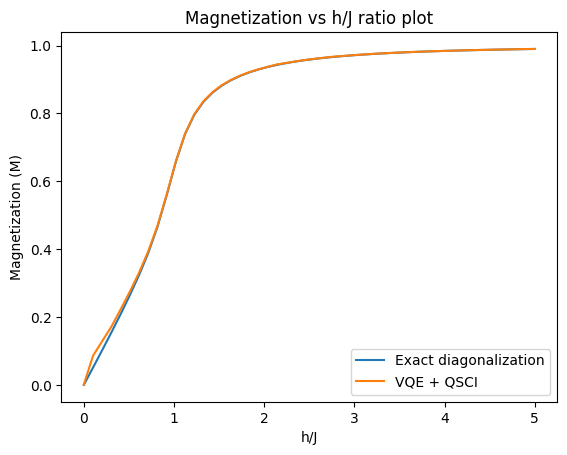

In [ ]:
magnetization = []
exact_magnetization = []

for i in range(len(h_J)):
    magnetization.append(calculate_magnetization(ground_states[i]))

    qsv = QuantumStateVector(n_qubits, exact_ground_states[i])
    exact_magnetization.append(calculate_magnetization(qsv)) # Works with abs

plt.xlabel('h/J')
plt.ylabel('Magnetization (M)')
plt.title('Magnetization vs h/J ratio plot')
plt.plot(h_J, exact_magnetization, label='Exact diagonalization')
plt.plot(h_J, magnetization, label='VQE + QSCI')
plt.legend()

#### **Magnetic Susceptibility**

The *magnetic susceptibility* $\chi$ is a measure of how the magnetization of a system responds to an external magnetic field. It is defined as:
$$
\chi = \frac{\partial M}{\partial h}
$$
where $M$ is the magnetization and $h$ is the transverse field. The magnetic susceptibility diverges at the critical point, indicating a phase transition.

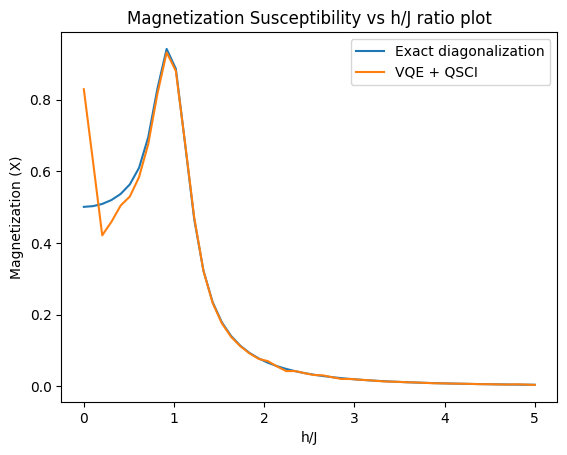

In [ ]:
plt.xlabel('h/J')
plt.ylabel('Magnetization (Χ)')
plt.title('Magnetization Susceptibility vs h/J ratio plot')
plt.plot(h_J, np.gradient(exact_magnetization, h_J[1] - h_J[0]), label='Exact diagonalization')
plt.plot(h_J, np.gradient(magnetization, h_J[1] - h_J[0]), label='VQE + QSCI')
plt.legend()

The Magnetic Susceptibility is approximately 0 for $h/J > 1$ and finite for $h/J < 1$. The Magnetic Susceptibility diverges at $h/J = 1$. This is because the system undergoes a phase transition at this point, where the ground state changes from a doublet of degenerate states with non-zero magnetization to a unique state with zero magnetization $h/J = 1 $.

## **Conclusion**

In this tutorial, we looked at the implementation Transverse Field Ising Models using QURI-SDK. Precisely, we covered:
- Defining the parametrized Hamiltonian for Transverse Field Ising Models. 
- Approximating the ground state of the TFIM Hamiltonian using VQE with different ansatzs.
- Further improving in ground state energy using Statistical Phase Estimation (SPE), Quantum State Compression and Inference (QSCI) methods.
- Calculating magnetization, magentic susceptibility for ground state wavefunction and showing divergence at the critical point (Quantum Phase Transition).

## **Reference*:*

[Transverse Field Ising Model Tutorial](https://phas.ubc.ca/~seme/516/smtutorial2.pdf)